Universidad Simón Bolívar. \\
Departamento de Cómputo Científico. \\
CO-6612, Introducción a Redes Neuronales. \\
TDD 2020. \\
Prof. Minaya Villasana. \\
Amin Arriaga 16-10072. 
# **Tarea 6: SVM**

In [ ]:
import numpy as np
import csv
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from random import uniform
from math import e

In [ ]:
# Montamos el drive para obtener los archivos 
# mnist_test.csv,   mnist_train.csv
from google.colab import drive
drive.mount('/content/drive')

## **Problema 1**
Para datos bidimensionales $x = (x_1, x_2)$, ¿cual es la transformacion $\phi(x)$ para el kernel $k(x, z) = (x^tz + 1)^2$.

$$k(x, z) = (x^tz + 1)^2$$
$$ = (x_1z_1 + x_2z_2 + 1)^2$$
$$ = x_1^2z_1^2 + 2x_1z_1 + 2x_1x_2z_1z_2 + 2x_2z_2 + x_2^2z_2^2 + 1$$ \\
$$ = \left[ \begin{array}{crl} x_1^2 & \sqrt{2}x_1 & \sqrt{2}x_1x_2 &  \sqrt{2}x_2 & x_2^2 & 1\end{array} \right]
\left[ \begin{array}{crl} z_1^2 \\ \sqrt{2}z_1 \\ \sqrt{2}z_1z_2 \\ \sqrt{2}z_2 \\ z_2^2 \\ 1 \end{array} \right]$$
$$ = \phi^t(x) \phi(z)$$

Por lo tanto, la transformacion para el kernel $k(x, z) = (x^tz + 1)^2$ para $x = (x_1, x_2)$ es

$$\phi(x) = \left[ \begin{array}{crl} x_1^2 \\ \sqrt{2}x_1 \\ \sqrt{2}x_1x_2 \\ \sqrt{2}x_2 \\ x_2^2 \\ 1 \end{array} \right] $$

## **Problema 2**

#### **Leyendo y graficando los datos**

In [ ]:
def readCSV(file):
  """ Leer datos de un archivo .csv """
  with open(file, newline='') as File:  
      reader = csv.reader(File)
      X = []
      Y = []
      for r in reader:
          X.append(np.array([float(r[0]), float(r[1])]))
          Y.append(2*float(r[2]) - 1)
          
  return X, Y

Leemos y graficamos los datos.

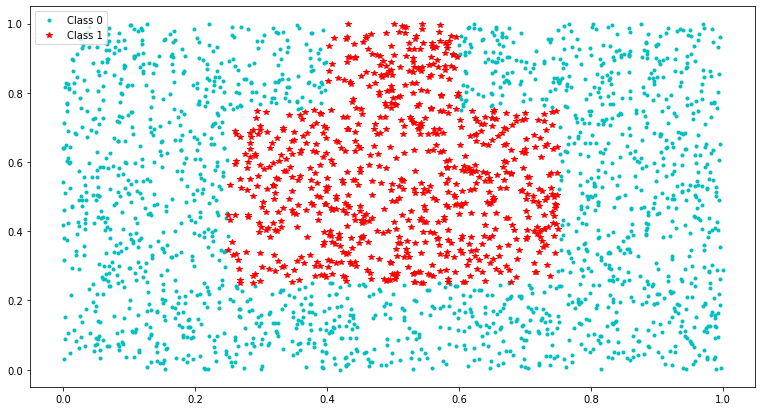

In [ ]:
X, Y = readCSV("/content/drive/My Drive/lego.csv")
X, Y = X[:2500], Y[:2500]
X_0, X_1 = [], []
for i, y in enumerate(Y):
  if y > 0: X_1.append(X[i])
  else: X_0.append(X[i])

plt.figure(figsize=(13,7))
plt.plot([x[0] for x in X_0], [x[1] for x in X_0], '.c', label="Class 0")
plt.plot([x[0] for x in X_1], [x[1] for x in X_1], '*r', label="Class 1")
plt.legend()
plt.show()

Graficamos y usaremos únicamente la mitad (2500) de los datos, pues parecen ser suficiente para crear el clasificador y se acelera la ejecución.

### **Implementacion del SVM**

In [ ]:
class SVM:
  def __init__(self, X, Y, k):
    self.X = X 
    self.Y = Y 
    self.k = k

  def change_data(self, X, Y):
    self.X = X
    self.Y = Y

  def change_kernel(self, k):
    self.k = k

  def train(self, C, solver = cp.ECOS):
    N = len(self.X)
    K = [[0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
      for j in range(i, N):
        K[i][j] = self.k(self.X[i], self.X[j])
        K[j][i] = K[i][j]
    P = matrix(np.array([[self.Y[i]*self.Y[j]*K[i][j] for j in range(N)] for i in range(N)]), tc='d')
    q = matrix(-np.ones(N), tc='d')
    G = matrix(np.concatenate((np.identity(N), -np.identity(N))))
    h = matrix(np.concatenate((np.array([C]*N), np.array([0]*N))), tc='d')
    A = matrix(np.array([float(y) for y in self.Y]).astype('float'), tc='d')
    A = A.T
    b = matrix([0.])
    solvers.options['show_progress'] = False
    L = solvers.qp(P,q,G,h,A,b)['x']

    # Multiplicadores de Lagrange y vectores de soporte junto a sus etiquetas.
    self.L = []
    self.BSV = []
    self.label_BSV = []
    self.SV = []
    self.label_SV = []
    S = []
    for i, l in enumerate(L):
      if l >= 0.001:
        self.L.append(l)
        self.BSV.append(self.X[i])
        self.label_BSV.append(self.Y[i])
        S.append(i)
        if (l < C-1e-5):
          self.SV.append(self.X[i])
          self.label_SV.append(self.Y[i])

    # Calculamos el sesgo.
    self.bias = sum(self.Y[i] - sum(L[j] * self.Y[j] * self.k(self.X[j], self.X[i]) for j in S) for i in S)/len(S)

  def predict(self, x):
    N = len(self.L)
    return sum(self.L[i]*self.label_BSV[i]*self.k(self.BSV[i], x) for i in range(N)) + self.bias

### **Ejecucion del Problema 2**

In [ ]:
def get_pol(p):
  def POLYNOMIAL(x, z, p=p):
    return (np.dot(x, z) + 1)**p
  return POLYNOMIAL

def get_gauss(a):
  def GAUSS(x, z, a=a):
    return e**(-np.dot(x-z, x-z)/((a**2)*2))
  return GAUSS

def get_tanh(b):
  def TANH(x, z, b=b):
    E = e**-(np.dot(x, z) + b)
    return (1-E)/(1+E)
  return TANH

def problema2(K, *C, solver = cp.ECOS):
  x = np.linspace(0.1, 0.9, 80)
  y = np.linspace(0.0, 1.0, 100)
  X_p, Y_p = np.meshgrid(x,y)

  for c in C:
    svm = SVM(X, Y, K)
    svm.train(c, solver = solver)

    print("\t\t\t\033[1;1mGRAFICA CON KERNEL: " + K.__name__ + "; Y C = " + str(c))
    Contour = [[svm.predict([i, j]) for i in x] for j in y]
    plt.figure(figsize=(13,7))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.plot([v[0] for v in svm.BSV], 
             [v[1] for v in svm.BSV], 
             '*b', label="BSV")
    plt.plot([v[0] for v in svm.SV], 
             [v[1] for v in svm.SV], 
             'o', color='black', label="SV")
    plt.plot([x[0] for x in X_0], [x[1] for x in X_0], '.c', label="Class 0")
    plt.plot([x[0] for x in X_1], [x[1] for x in X_1], '.r', label="Class 1")
    plt.contour(X_p, Y_p, Contour, [0], colors='black')
    plt.contour(X_p, Y_p, Contour, [-1], colors='black', linestyles='dashed')
    plt.contour(X_p, Y_p, Contour, [1], colors='black', linestyles='dashed')
    plt.legend()
    plt.show()
    print("\n\n\n")

#### **NOTA:** 
Las gráficas de los vectores de soporte no son muy exactas debido a los calculos imperfectos, sin embargo dan una idea sobre el comportamiento del clasificador.

#### **POLINOMIAL**

			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 5


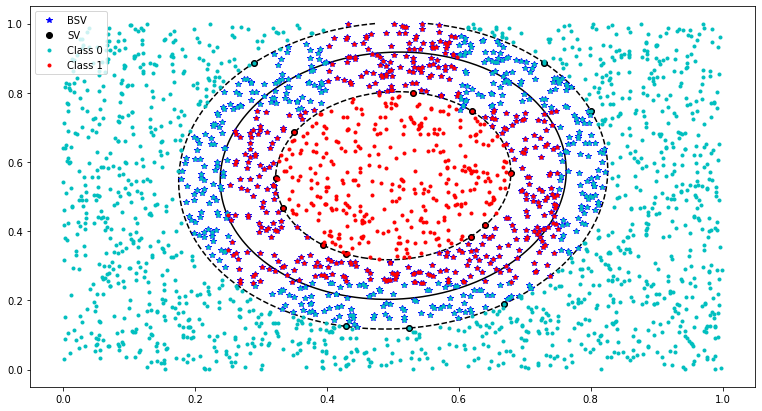





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 10


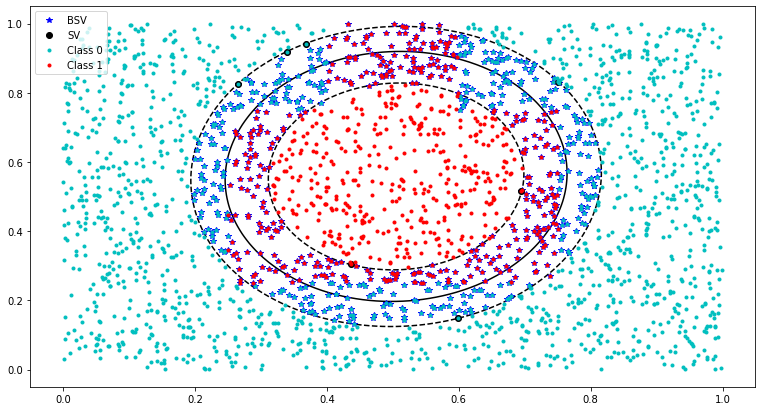





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 50


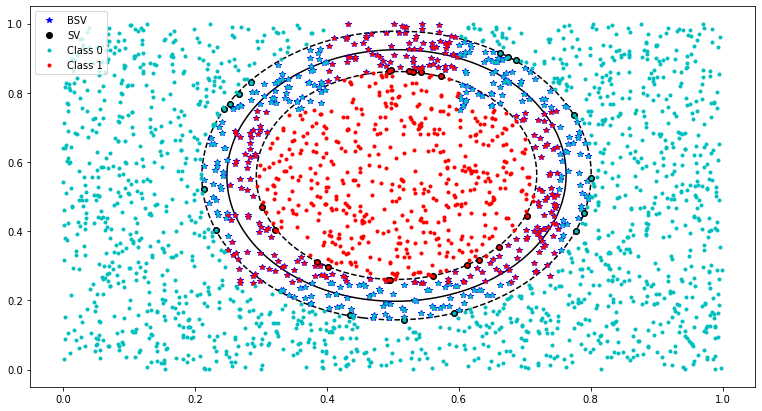





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 100


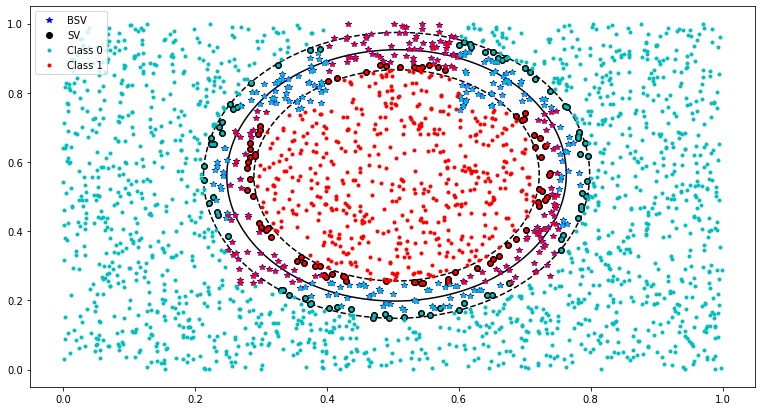

In [ ]:
problema2(get_pol(2), 5, 10, 50, 100)

			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 5


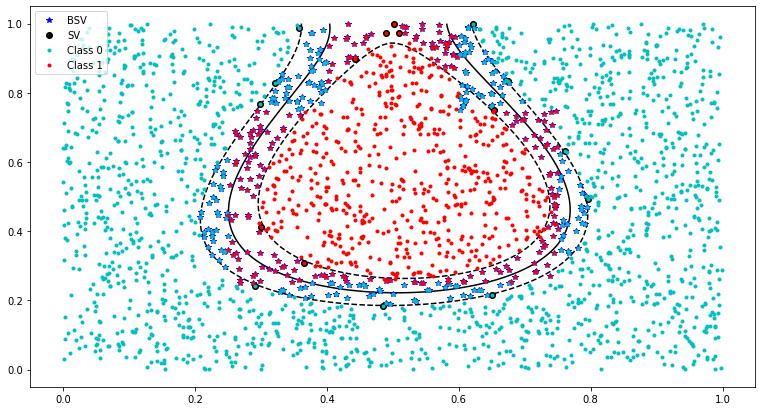





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 10


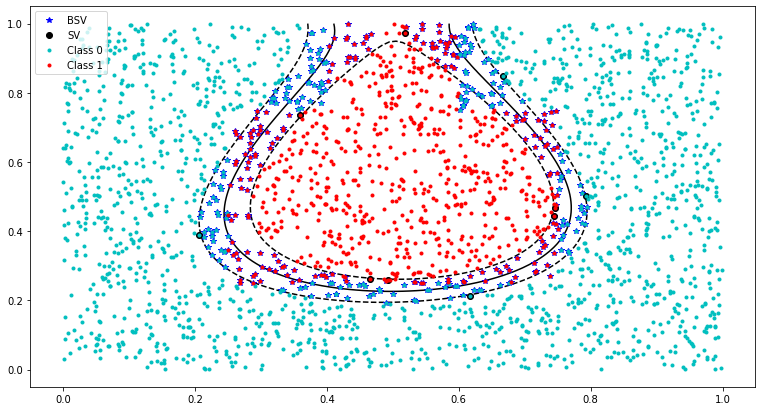





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 50


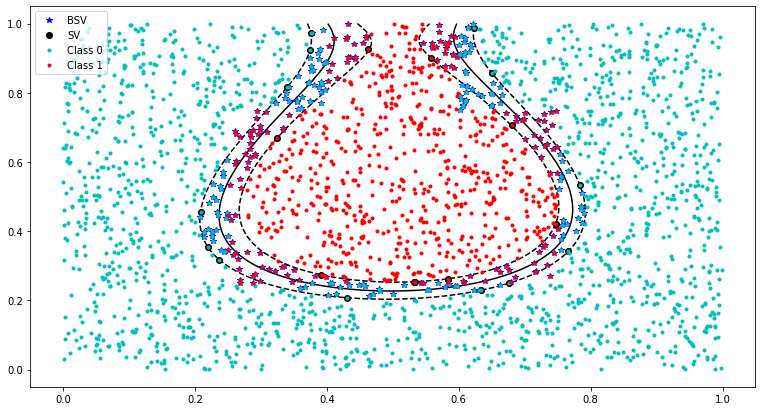





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 100


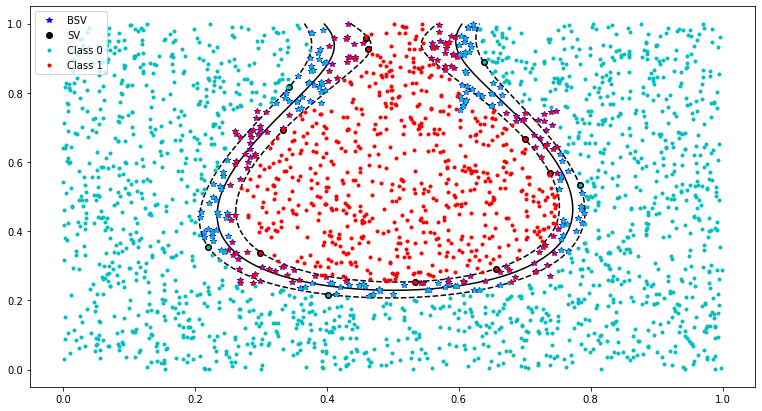

In [ ]:
problema2(get_pol(5), 5, 10, 50, 100)

			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 5


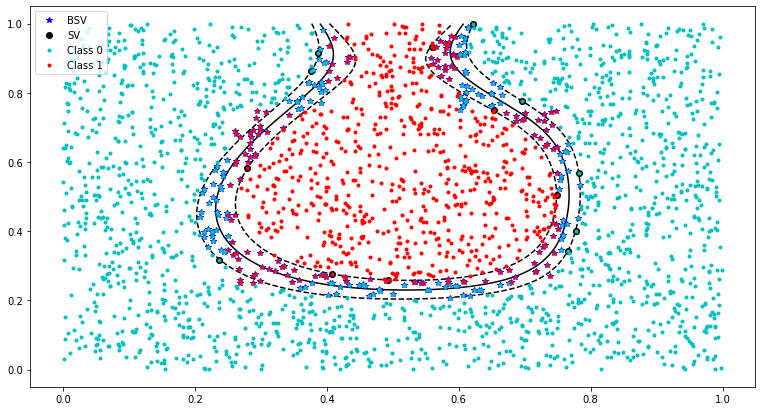





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 10


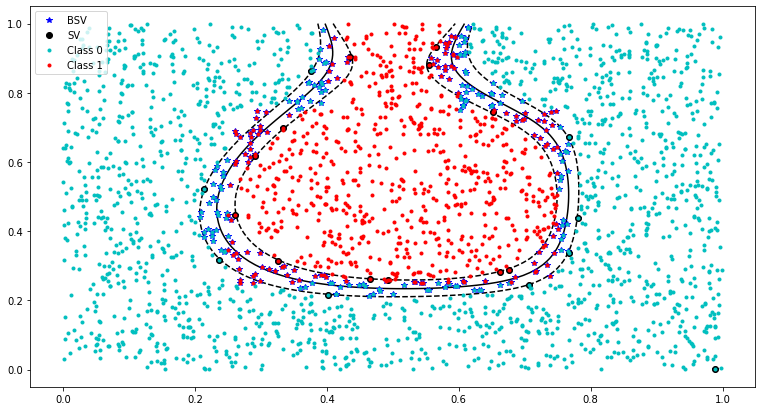





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 50


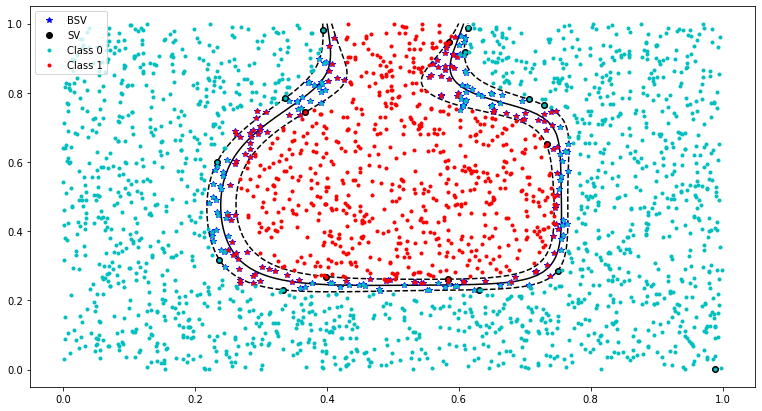





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 100


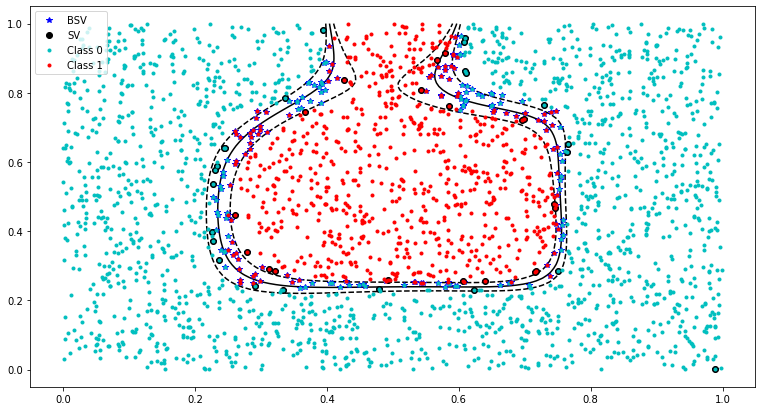

In [ ]:
problema2(get_pol(10), 5, 10, 50, 100)

			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 5


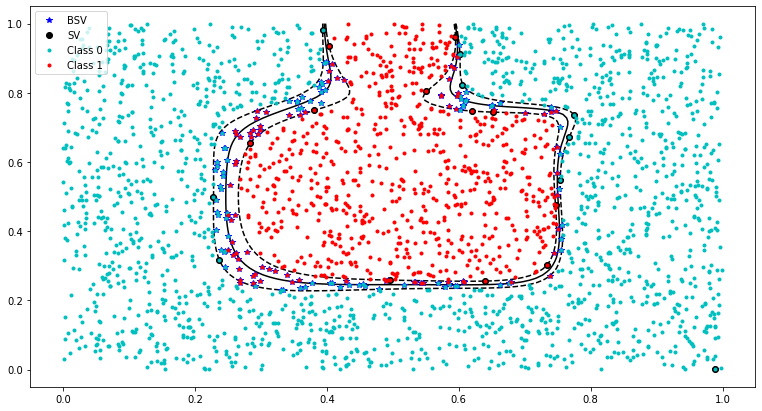





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 10


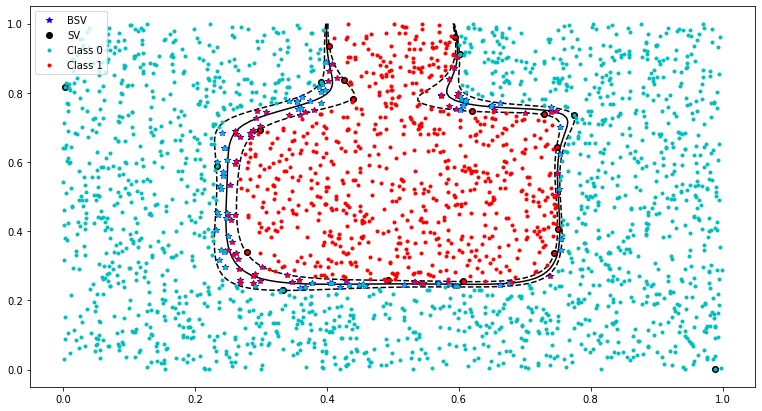





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 50


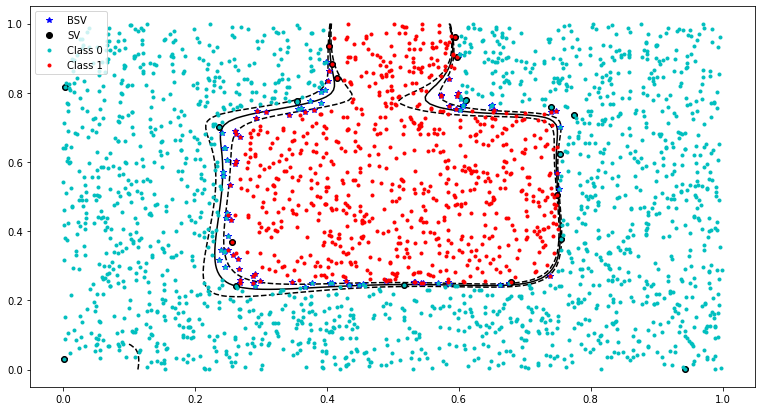





			GRAFICA CON KERNEL: POLYNOMIAL; Y C = 100


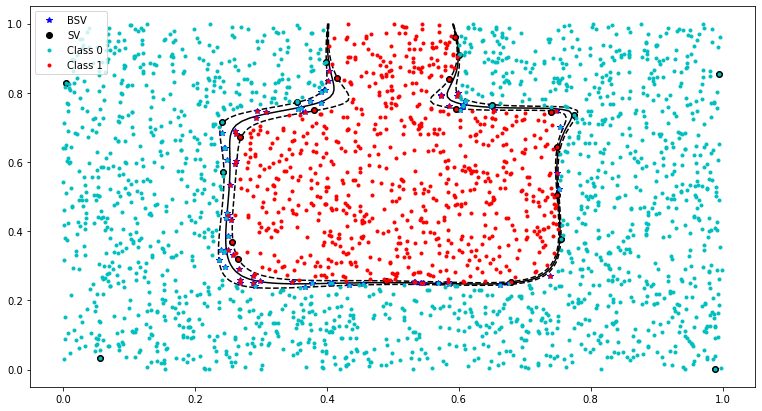

In [ ]:
problema2(get_pol(15), 5, 10, 50, 100)

#### **GAUSS**

			GRAFICA CON KERNEL: GAUSS; Y C = 5


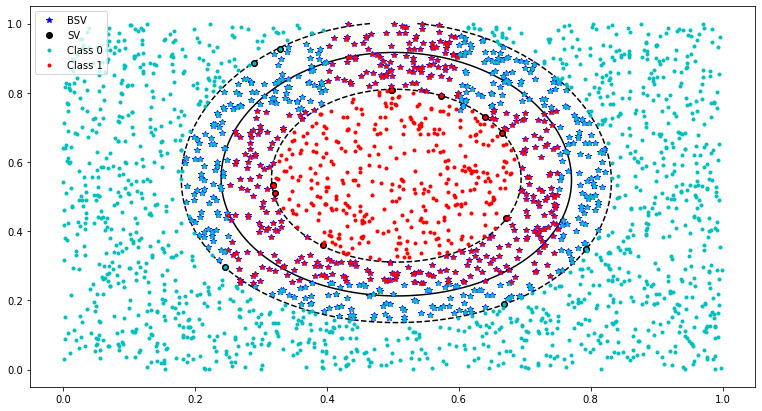





			GRAFICA CON KERNEL: GAUSS; Y C = 10


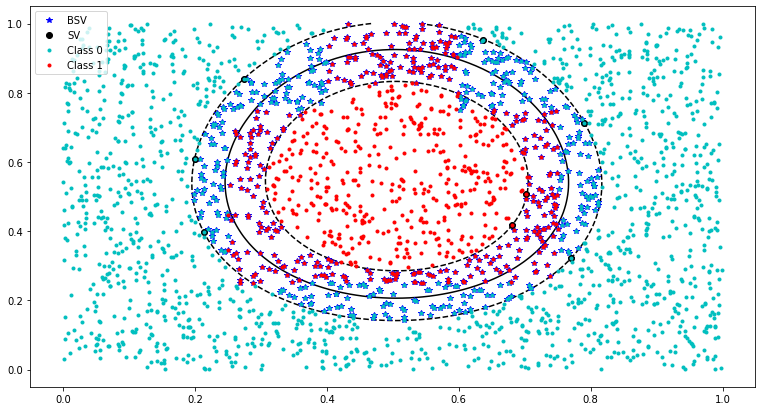





			GRAFICA CON KERNEL: GAUSS; Y C = 50


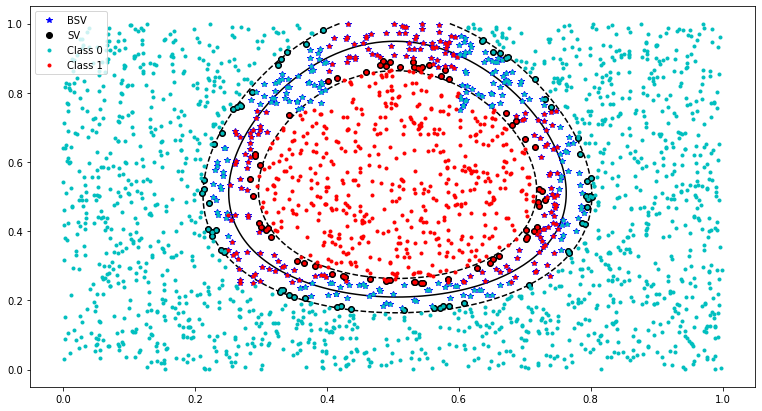





			GRAFICA CON KERNEL: GAUSS; Y C = 100


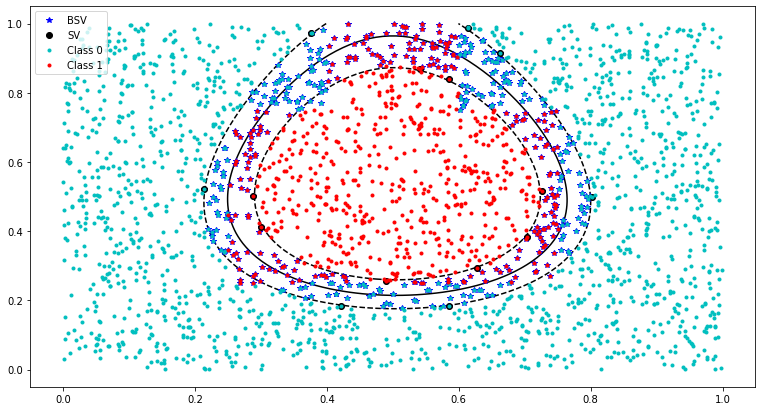

In [ ]:
problema2(get_gauss(1), 5, 10, 50, 100)

			GRAFICA CON KERNEL: GAUSS; Y C = 5


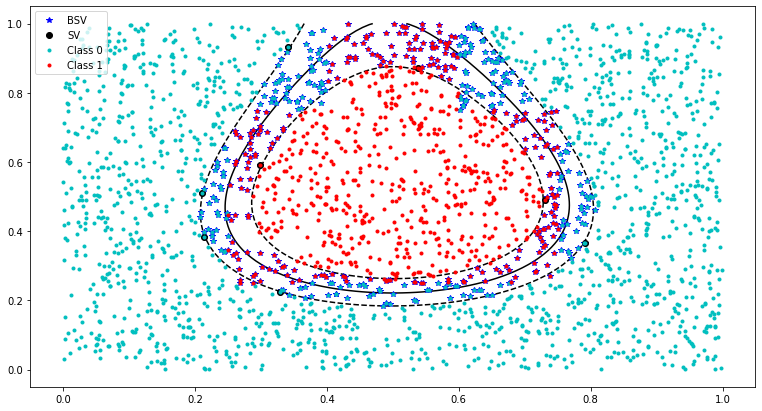





			GRAFICA CON KERNEL: GAUSS; Y C = 10


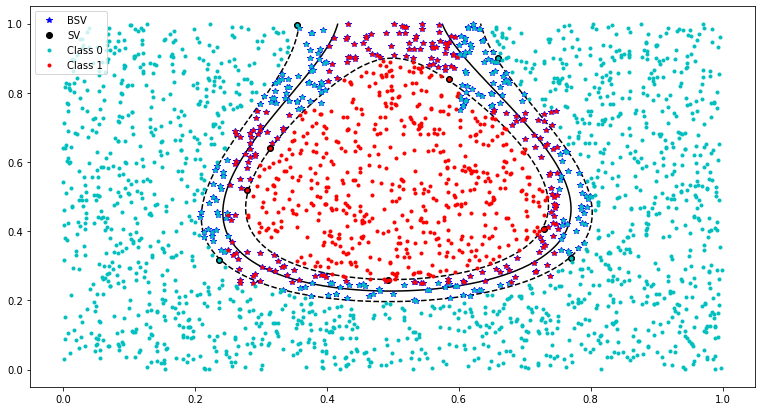





			GRAFICA CON KERNEL: GAUSS; Y C = 50


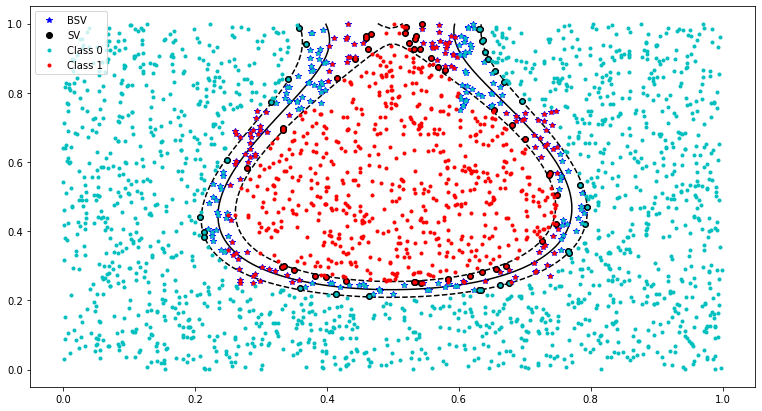





			GRAFICA CON KERNEL: GAUSS; Y C = 100


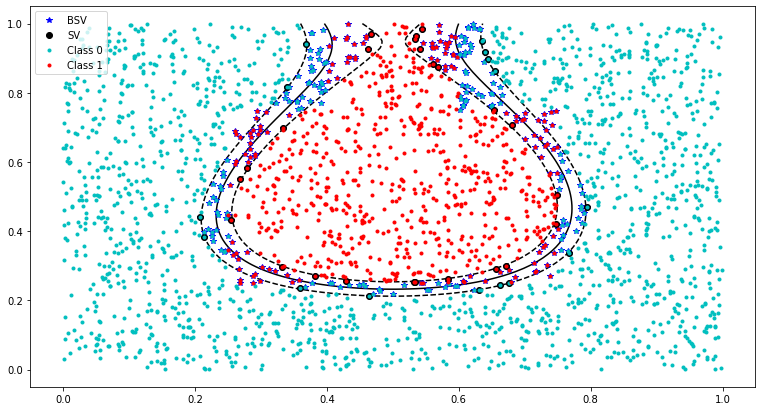

In [ ]:
problema2(get_gauss(0.5), 5, 10, 50, 100)

			GRAFICA CON KERNEL: GAUSS; Y C = 5


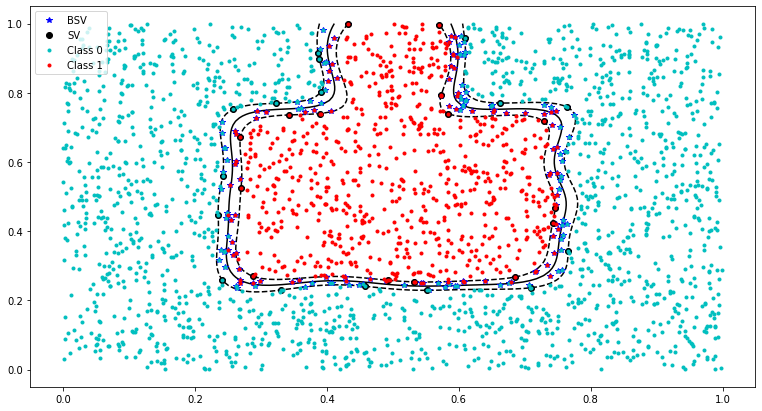





			GRAFICA CON KERNEL: GAUSS; Y C = 10


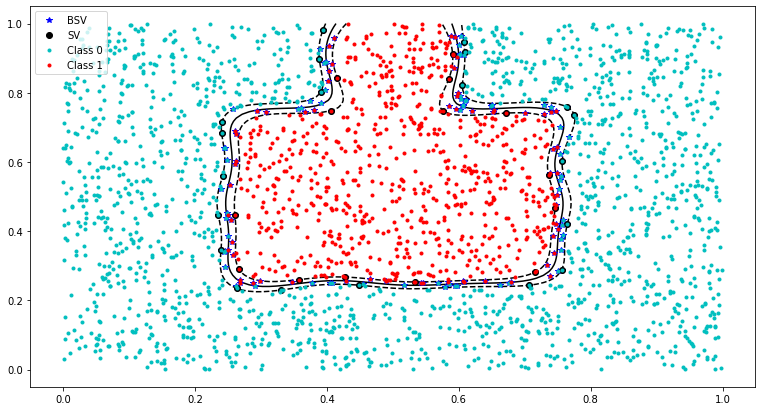





			GRAFICA CON KERNEL: GAUSS; Y C = 50


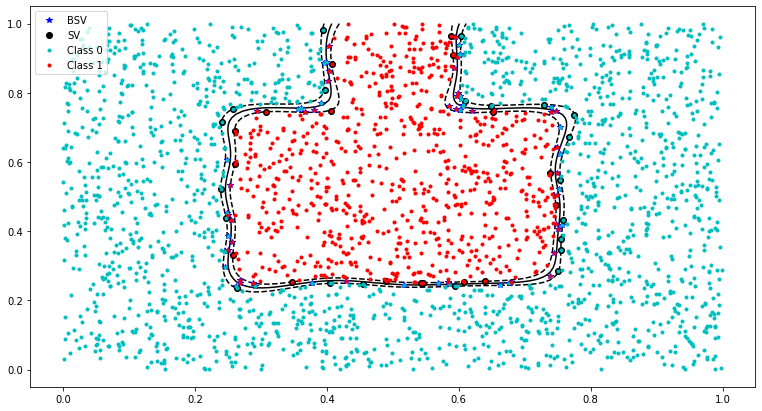





			GRAFICA CON KERNEL: GAUSS; Y C = 100


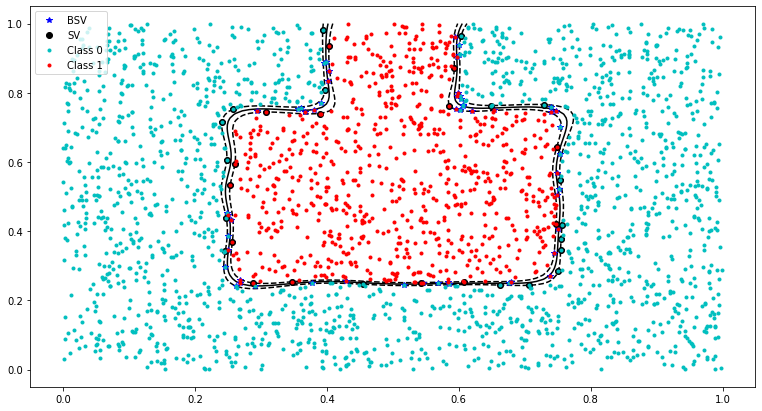

In [ ]:
problema2(get_gauss(0.1), 5, 10, 50, 100)

			GRAFICA CON KERNEL: GAUSS; Y C = 5


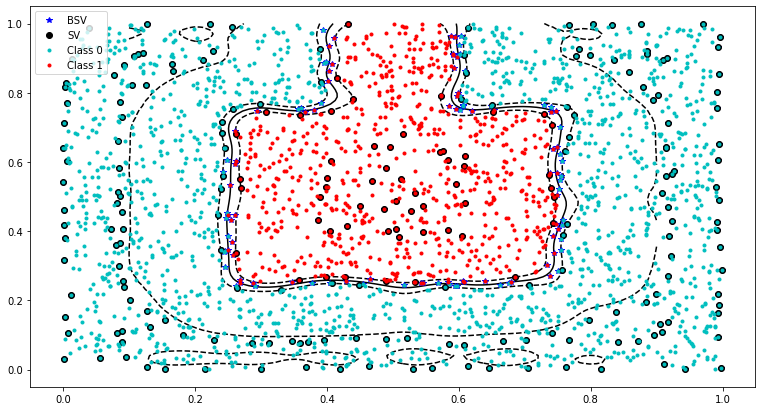





			GRAFICA CON KERNEL: GAUSS; Y C = 10


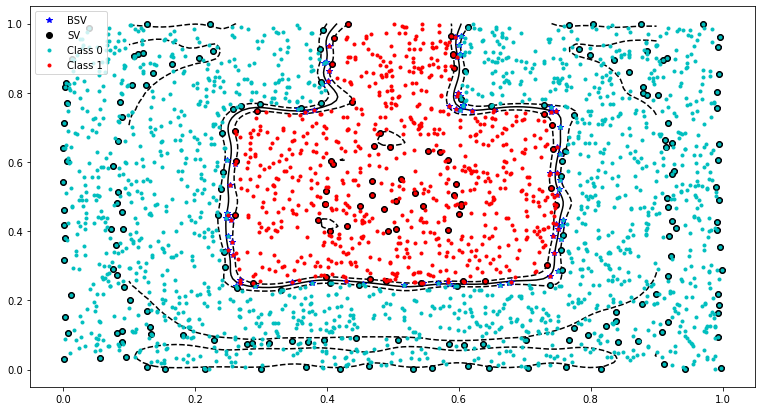





			GRAFICA CON KERNEL: GAUSS; Y C = 50


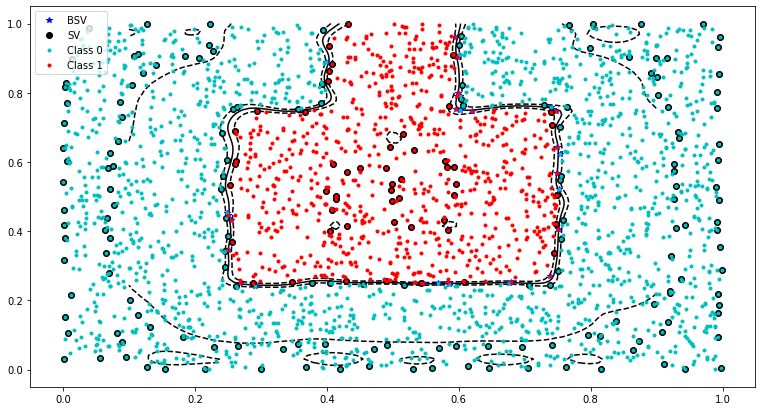





			GRAFICA CON KERNEL: GAUSS; Y C = 100


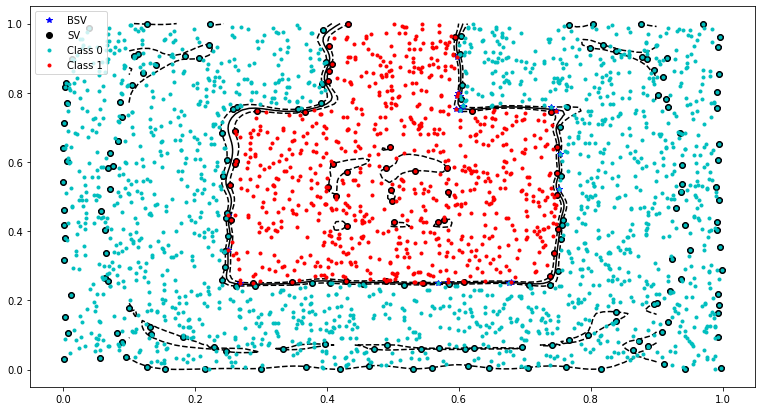

In [ ]:
problema2(get_gauss(0.05), 5, 10, 50, 100)

### **Conclusiones**

Con respecto al SVM con kernel polinomial, se necesitó una complejidad alta (15) para lograr un clasificador decente, pues la figura que generan los gatos es "recta" lo que dificulta al kernel polinomial poder clasificarlos. Respecto al kernel gaussiano, los resultados fueron asombrosos, para $\sigma = 0.1$ el clasificador es muy preciso, y al aumentarlo o disminuirlo las resultados empeoran. Con ambos kernels el clasificador mejoraba para $C$ altos, lo que significa que se necesita bastante presión para clasificar correctamente los datos. Esto se debe a que hay tantos datos que los nuevos datos seran muy parecidos a algun dato viejo, por lo tanto, el SVM es efectivo si clasifica correctamente los patrones originales.

No se probo el kernel sigmoidal pues el optimizador cuadratico daba error a tratar de resolver el problema de minimizacion.